# Classifying Fashion-MNIST

Now it's your turn to build and train a neural network. You'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

In this notebook, you'll build your own neural network. For the most part, you could just copy and paste the code from Part 3, but you wouldn't be learning. It's important for you to write the code yourself and get it to work. Feel free to consult the previous notebook though as you work through this.

First off, let's load the dataset through torchvision.

In [436]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"


import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import time
import pandas as pd
from collections import OrderedDict

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms

## Loading the FMNIST dataset

In [437]:
transform = transforms.ToTensor()

trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

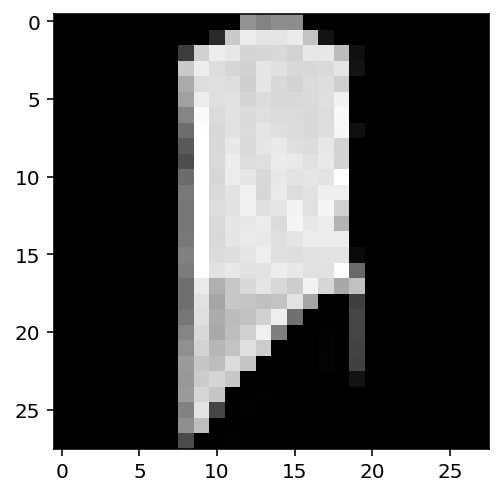

In [438]:
image, label = next(iter(trainloader))
test_image = image[0:1]
plt.imshow(test_image[0].reshape((28, 28)), cmap="gray")
plt.show()

## Building the network

Here you should define your network. As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. You should include at least one hidden layer. We suggest you use ReLU activations for the layers and to return the logits from the forward pass. It's up to you how many layers you add and the size of those layers.

In [439]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [440]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(784, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
    nn.Softmax(dim=1)
)

In [441]:
model(test_image).shape

torch.Size([1, 10])

# Train the network

Now you should create your network and train it. First you'll want to define [the criterion](http://pytorch.org/docs/master/nn.html#loss-functions) ( something like `nn.CrossEntropyLoss`) and [the optimizer](http://pytorch.org/docs/master/optim.html) (typically `optim.SGD` or `optim.Adam`).

Then write the training code. Remember the training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

By adjusting the hyperparameters (hidden units, learning rate, etc), you should be able to get the training loss below 0.4.

In [442]:
def smoothen_metric(metric, window_size=40):
    return pd.Series(metric).rolling(window_size, min_periods=1).mean()

In [443]:
def evaluate_metric_on_dataset(model, loader, evaluate_metric):
    ground_truth, predictions = map(
        torch.cat, 
        zip(*[
            [ground_truth, model(images)] 
            for images, ground_truth in loader]))
    
    return evaluate_metric(ground_truth, predictions)

In [444]:
def eval_accuracy(ground_truth, predictions):
    return float(
        (ground_truth == predictions.argmax(dim=1))
        .type(torch.FloatTensor)
        .mean())

In [445]:
def plot_metric(steps, metric_values):
    plt.plot(
        np.linspace(0, steps, len(metric_values)), 
        metric_values)

In [446]:
def plot_metrics(metrics, steps, model, xlim=None):
    plt.title("Loss")
    plt.xlim(xlim)
    plot_metric(
        steps, 
        smoothen_metric([m["training_loss"] for m in metrics]))
    plt.legend(["Training Loss"])
    plt.show()
    
    plt.title("Accuracy")
    plt.xlim(xlim)
    plot_metric(
        steps, 
        smoothen_metric([m["training_accuracy"] for m in metrics]))
    plt.title("Training Loss")
    plot_metric(
        steps, 
        smoothen_metric([m["testing_accuracy"] for m in metrics], window_size=80))
    plt.legend(["Training Accuracy", "Testing Accuracy"])
    plt.show()

In [447]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [448]:
def train_model(model, criterion, optimizer, epochs=3, print_every=40):
    steps = 0
    metrics = []

    total_steps = epochs * len(iter(trainloader))
    
    for e in range(epochs):
        for images, labels in iter(trainloader):
            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            metrics.append({
                "training_loss": loss.item(),
                "training_accuracy": eval_accuracy(labels, output),
                "testing_accuracy": (
                    evaluate_metric_on_dataset(model, testloader, eval_accuracy)
                    if steps % print_every == 0
                    else metrics[-1]["testing_accuracy"])
            })

            if steps % print_every == 0:
                clear_output(wait=True)

                plot_metrics(metrics, steps, model, xlim=(0, total_steps))

            steps += 1

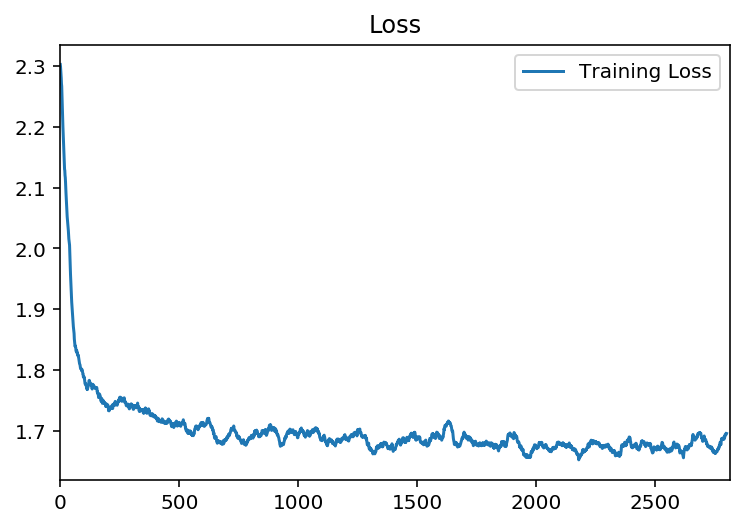

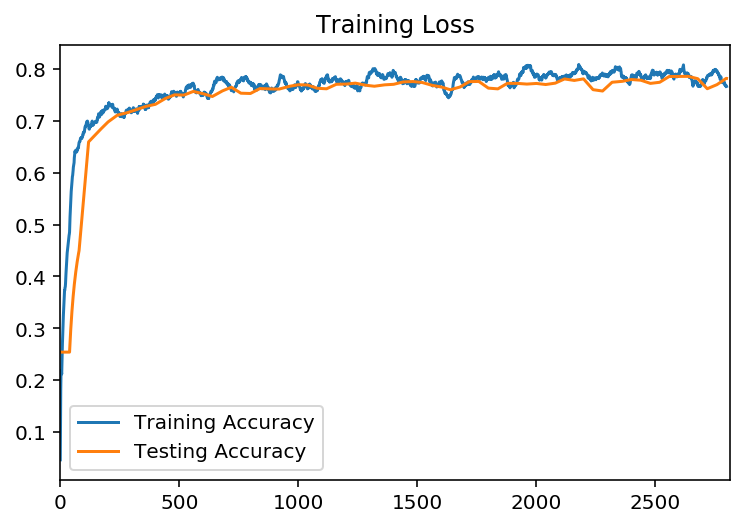

In [449]:
train_model(model, criterion, optimizer)

In [450]:
print(f"Train accuracy: {evaluate_metric_on_dataset(model, trainloader, eval_accuracy)}")

Train accuracy: 0.7667833566665649


In [451]:
print(f"Test accuracy: {evaluate_metric_on_dataset(model, testloader, eval_accuracy)}")

Test accuracy: 0.7531999945640564


## Test on test images

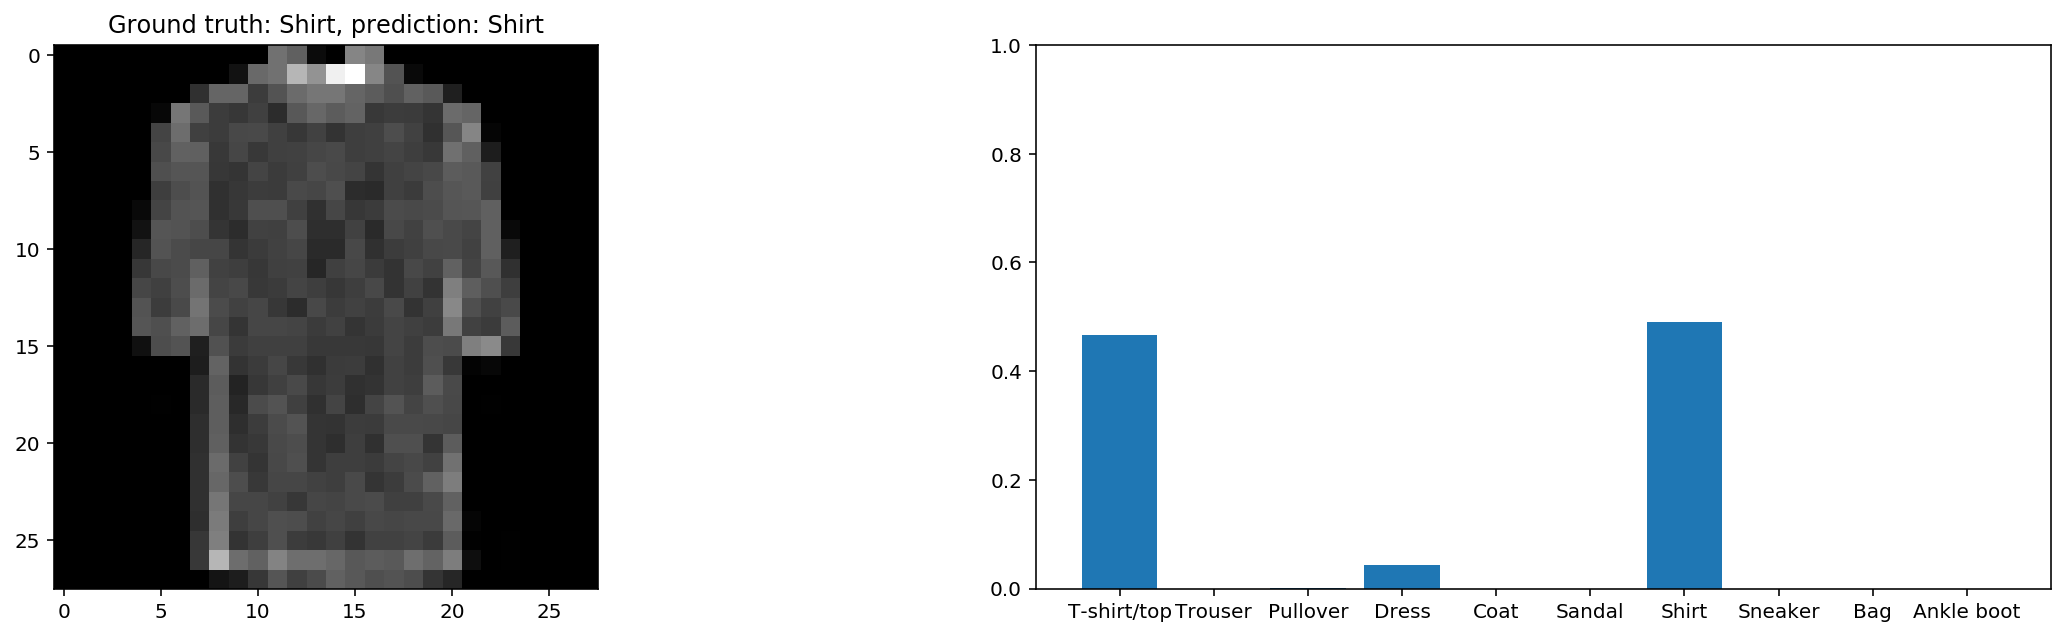

In [334]:
idx_to_class = {idx: cls for cls, idx in trainset.class_to_idx.items()}

img, gt = iter(testloader).next()
pred = model(img[:1])
pred_int = pred.argmax(dim=1)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title(f"Ground truth: {idx_to_class[int(gt[0])]}, prediction: {idx_to_class[int(pred_int[0])]}")
ax[0].imshow(img[0].reshape(28, 28), cmap="gray")
ax[1].set_ylim((0, 1))
ax[1].bar(idx_to_class.values(), pred[0].detach().numpy())
plt.show()

## Save and load model

### General solution: Pickle it!

In [350]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('model.pkl', 'rb') as f:
    model_new = pickle.load(f)

In [353]:
evaluate_metric_on_dataset(model_new, testloader, eval_accuracy)

0.8424999713897705

### Only state_dict with pytorch

In [355]:
torch.save(model.state_dict(), 'checkpoint.pth')

### Save the whole model with pytorch

In [356]:
torch.save(model, 'torch_model.model')

/home/mariosk/.virtualenvs/computer_vision/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [357]:
model_new_torch = torch.load('torch_model.model')

In [358]:
evaluate_metric_on_dataset(model_new_torch, testloader, eval_accuracy)

0.8424999713897705

## Loading data from a directory

In [392]:
!mkdir some_fmnist
for cls in trainset.classes:
    !mkdir ./some_fmnist/cat_{re.sub("[^a-zA-Z]", "_", cls)}

In [396]:
for i ,[imgs, labs] in enumerate(trainloader):
    if i % 50 == 0:
        print(i)
    for img, lab in zip(imgs, labs):
        dir_name = f"./some_fmnist/cat_{re.sub('[^a-zA-Z]', '_', idx_to_class[int(lab)])}"
        image_hash = hash(str(img.numpy()))
        path = f"{dir_name}/{image_hash}.png"

        plt.imsave(path, img.reshape(28, 28).numpy())

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900


In [397]:
train_data_folder = datasets.ImageFolder("./some_fmnist", transform=transform)

trainloader_folder = torch.utils.data.DataLoader(train_data_folder, batch_size=32)

In [398]:
train_data_folder.classes

['cat_Ankle_boot',
 'cat_Bag',
 'cat_Coat',
 'cat_Dress',
 'cat_Pullover',
 'cat_Sandal',
 'cat_Shirt',
 'cat_Sneaker',
 'cat_T_shirt_top',
 'cat_Trouser']